In [1]:
library(tidyverse)
library(alakazam)
library(shazam)
library(ggplot2)
library(magrittr)
library(ggpubr)
library(stats)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.

As of v1.0.0 the AIRR Rearrangement schema is now the default fi

# Read in data

In [2]:
meta <- read.csv('../all_sample_meta.csv', header = T)
files <- dir('../data/')

In [5]:
files 
length(files)

[1] "GW"   "GZR"  "HXR"  "HXR2" "HXX"  "LGY"  "LL"   "LL2"  "MXY"  "QJY" 
[11] "SQ"   "WYF"  "WYF2" "WYY"  "XH"   "XYY"  "XYY2" "ZH"   "ZMY1" "ZPP" 
[21] "ZPP2" "ZS"

[1] 22

In [7]:
tmp <- read.csv('../data/GW/10X_clone-pass_germ-pass.tsv', header = T, sep = '\t')
head(tmp,2)
dim(tmp)

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,⋯,umi_count,v_call_10x,d_call_10x,j_call_10x,junction_10x,junction_10x_aa,germline_alignment_d_mask,germline_v_call,germline_d_call,germline_j_call
,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,TGGCGCAGTCAATGTC-1_contig_1,CTCACTCTGCTGAAGAAAACCAGCCCTGCAGCTCTGGGAGAGGAGCCCCAGCCCTGGGATTCCCAGCTGTTTCTGCTTGCTGATCAGGACTGCACACAGAGAACTCACCATGGAGTTTGGGCTGAGCTGGGTTTTCCTTGTTGCTATTTTAAAAGGTGTCCAGTGTGAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGATGGGAGTAGCACAAGCTACGCGGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,IGHV3-74*01,IGHD3-22*01,IGHJ4*02,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGNNNNNNNNTATTACTATGATAGTAGTGGTTATTACTACNNNNNNNNCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,TGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGG,⋯,49,IGHV3-74,IGHD3-22,IGHJ4,TGTGCAAGAGCCCAGTCTTATTACTATGATAGTAGTGGTTATTACTACGAGGGGGGCTTTGACTACTGG,CARAQSYYYDSSGYYYEGGFDYW,GAGGTGCAGCTGGTGGAGTCCGGGGGA...GGCTTAGTTCAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTACTGGATGCACTGGGTCCGCCAAGCTCCAGGGAAGGGGCTGGTGTGGGTCTCACGTATTAATAGTGAT......GGGAGTAGCACAAGCTACGCGGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACGCTGTATCTGCAAATGAACAGTCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCAAGAGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,IGHV3-74*01,IGHD3-22*01,IGHJ4*02
2,CTGCTGTGTTGGTTTG-1_contig_2,GAGCTCTGGGAGAGGAGCCCAGCACTAGAAGTCGGCGGTGTTTCCATTCGGTGATCAGCACTGAACACAGAGGACTCACCATGGAGTTTGGGCTGAGCTGGGTTTTCCTCGTTGCTCTTTTAAGAGGTGTCCAGTGTCAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGATGGAAGTAATAAATACTATGCAGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAAAGATTCGGAAACATGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,"IGHV3-30*04,IGHV3-30*18,IGHV3-30-3*03","IGHD1-14*01,IGHD3-10*01,IGHD3-10*02","IGHJ4*02,IGHJ5*02",CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGAT......GGAAGTAATAAATACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAAAGATTCGGAAACATGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTGGGAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGCTATGCTATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGGCAGTTATATCATATGAT......GGAAGTAATAAATACTACGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCTGTGTATTACTGTGCGAGAGANNCGGAANNNTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG,TGTGCGAAAGATTCGGAAACATGG,⋯,19,IGHV3-30,,IGHJ4,TG

[1] 1067   62

In [8]:
# different Ig class ratio 
HC_df <- data.frame(matrix(NA, ncol = dim(tmp)[2] + 1, nrow = 0))
SLE_df <- data.frame(matrix(NA, ncol = dim(tmp)[2] + 1, nrow = 0))
for (file in files){
    name = str_split(file,'_')[[1]][1]
    # assign(name, read.csv(paste0('./vdj/VDJtools/bcr_data/',file),header = T))
    tmp <-  read.csv(paste0('../data/',file,'/10X_clone-pass_germ-pass.tsv'),header = T,sep = '\t')
    tmp %<>% mutate(sample = name)
    if(meta$group[which(meta$name == name)] == 'HC' ){
        HC_df <- rbind(HC_df,tmp)
    }else if(meta$group[which(meta$name == name)] == 'SLE'){
        SLE_df <- rbind(SLE_df, tmp)
    }
}


In [9]:
dim(HC_df)
dim(SLE_df)

[1] 4913   63

[1] 32888    63

In [10]:
SLE_df$disease <- 'SLE'
HC_df$disease <- 'HC'
all_df <-rbind(SLE_df, HC_df)

# SHM

In [54]:
db_obs_hc <- observedMutations(HC_df, sequenceColumn="sequence_alignment",
                            germlineColumn="germline_alignment_d_mask",
                            regionDefinition=NULL,
                            frequency=TRUE, 
                            nproc=24)
db_obs_sle <- observedMutations(SLE_df, sequenceColumn="sequence_alignment",
                            germlineColumn="germline_alignment_d_mask",
                            regionDefinition=NULL,
                            frequency=TRUE, 
                            nproc=32)
db_obs_hc$disease <- 'HC'
db_obs_sle$disease <- 'SLE'
db_obs_all <- rbind(db_obs_hc,db_obs_sle)
db_obs_all %<>% filter(c_call != '')

In [11]:
db_obs_all <- observedMutations(all_df, sequenceColumn="sequence_alignment",
                            germlineColumn="germline_alignment_d_mask",
                            regionDefinition=NULL,
                            frequency=TRUE, 
                            nproc=32)
db_obs_all %<>% filter(c_call != '')

In [55]:
g1 <- ggplot(db_obs_hc, aes(x=c_call, y=mu_freq_seq_r, fill=c_call)) +
    theme_bw() + ggtitle("HC Total mutations") +
    xlab("Isotype") + ylab("Mutation frequency") +
    scale_fill_manual(name="Isotype", values=IG_COLORS) +
    geom_boxplot()
g2 <-ggplot(db_obs_sle, aes(x=c_call, y=mu_freq_seq_r, fill=c_call)) +
    theme_bw() + ggtitle("SLE Total mutations") +
    xlab("Isotype") + ylab("Mutation frequency") +
    scale_fill_manual(name="Isotype", values=IG_COLORS) +
    geom_boxplot()
options(repr.plot.width=12, repr.plot.height=8)
ggarrange(g1, g2)

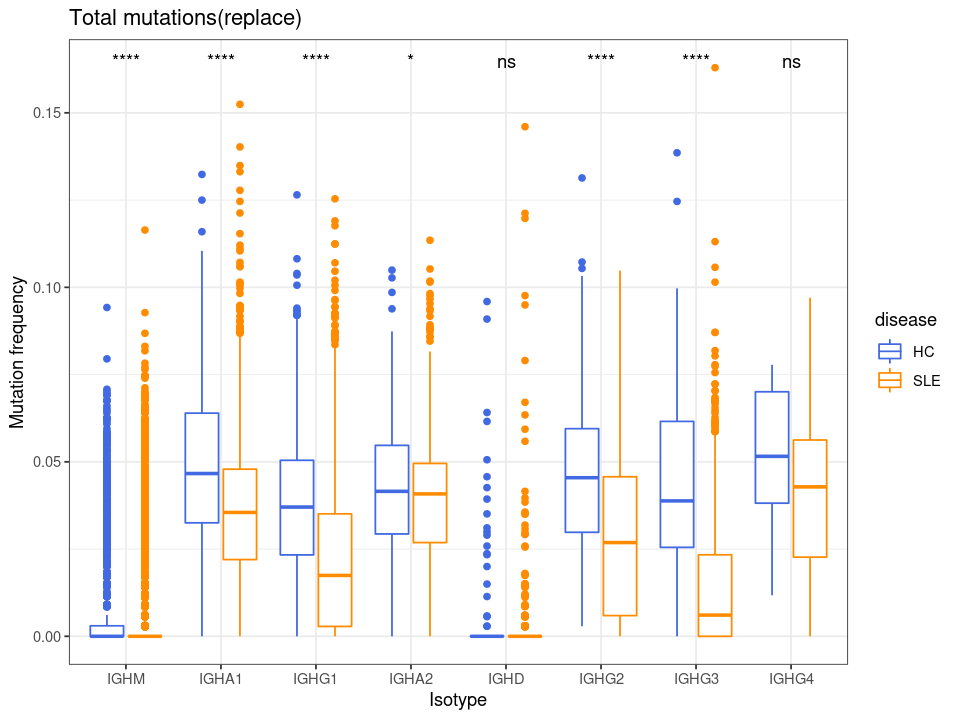

In [12]:
options(repr.plot.width=8, repr.plot.height=6)
ggboxplot(db_obs_all, "c_call", "mu_freq_seq_r", color = "disease",
 palette = c("#4169E1", "#FF8C00")) + ggtitle("Total mutations(replace)") +
    xlab("Isotype") + ylab("Mutation frequency") +
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")

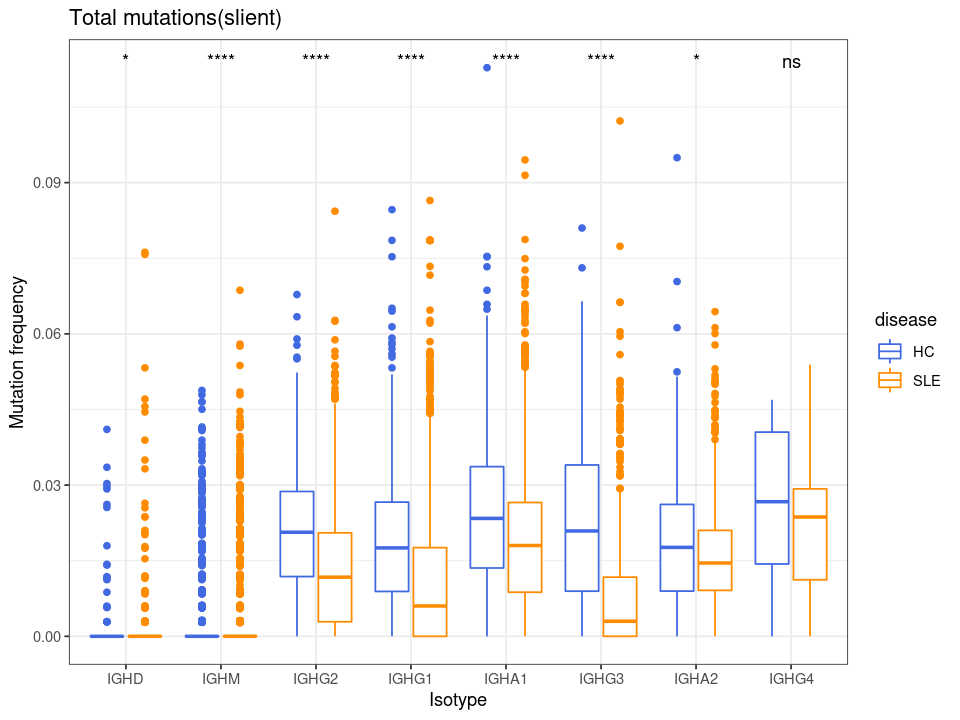

In [67]:
options(repr.plot.width=8, repr.plot.height=6)
ggboxplot(db_obs_all, "c_call", "mu_freq_seq_s", color = "disease",
 palette = c("#4169E1", "#FF8C00")) + ggtitle("Total mutations(slient)") +
    xlab("Isotype") + ylab("Mutation frequency") +
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")

In [14]:
db_obs_all %>% colnames()

[1] "sequence_id"               "sequence"                 
 [3] "rev_comp"                  "productive"               
 [5] "v_call"                    "d_call"                   
 [7] "j_call"                    "sequence_alignment"       
 [9] "germline_alignment"        "junction"                 
[11] "junction_aa"               "v_cigar"                  
[13] "d_cigar"                   "j_cigar"                  
[15] "stop_codon"                "vj_in_frame"              
[17] "locus"                     "junction_length"          
[19] "np1_length"                "np2_length"               
[21] "v_sequence_start"          "v_sequence_end"           
[23] "v_germline_start"          "v_germline_end"           
[25] "d_sequence_start"          "d_sequence_end"           
[27] "d_germline_start"          "d_germline_end"           
[29] "j_sequence_start"          "j_sequence_end"           
[31] "j_germline_start"          "j_germline_end"           
[33] "v_score"                   "v_identity"               
[35] "v_support"                 "d_score"                  
[37] "d_identity"                "d_support"                
[39] "j_score"                   "j_identity"               
[41] "j_support"                 "fwr1"                     
[43] "fwr2"                      "fwr3"                     
[45] "fwr4"                      "cdr1"                     
[47] "cdr2"                      "cdr3"                     
[49] "cell_id"                   "c_call"                   
[51] "consensus_count"           "clone_id"                 
[53] "umi_count"                 "v_call_10x"               
[55] "d_call_10x"                "j_call_10x"               
[57] "junction_10x"              "junction_10x_aa"          
[59] "germline_alignment_d_mask" "germline_v_call"          
[61] "germline_d_call"           "germline_j_call"          
[63] "sample"                    "disease"                  
[65] "mu_freq_seq_r"             "mu_freq_seq_s"

In [16]:
write.csv(db_obs_all,'/rd2/user/xiacr/sle/scripts/immcantaion/bcell_immacantation_SHM.csv')

# SHM target model

In [246]:
# Create substitution model using silent mutations
sub_model <- createSubstitutionMatrix(all_df, model="s", 
                                      sequenceColumn="sequence_alignment",
                                      germlineColumn="germline_alignment_d_mask",
                                      vCallColumn="v_call")

ERROR: Error in createMutabilityMatrix(all_df, sub_model, model = "s", sequenceColumn = "sequence_alignment", : Please supply a valid 5-mer substitutionModel.


In [253]:
model <- createTargetingModel(all_df, model="s", sequenceColumn="sequence_alignment", 
                              germlineColumn="germline_alignment_d_mask", vCallColumn="v_call")

Warning message in createMutabilityMatrix(db, sub_mat, model = model, sequenceColumn = sequenceColumn, :
“Insufficient number of mutations to infer some 5-mers. Filled with 0. ”


In [254]:
model

An object of class "TargetingModel"
Slot "name":
[1] ""

Slot "description":
[1] ""

Slot "species":
[1] ""

Slot "date":
[1] "2022-02-22"

Slot "citation":
[1] ""

Slot "mutability":
An object of class "MutabilityModel"
   [1] 1.987306e-03 1.340540e-03 1.006531e-03 1.287925e-03 1.405576e-03
   [6] 7.453551e-04 7.453551e-04 7.453551e-04 7.453551e-04 7.453551e-04
  [11] 2.085963e-03 9.650613e-04 1.817047e-03 1.079493e-03 1.486891e-03
  [16] 1.423037e-03 2.228621e-03 2.233394e-03 2.385082e-03 2.067533e-03
  [21] 1.560415e-03 1.319894e-03 1.450582e-03 1.374464e-03 1.426339e-03
  [26] 2.445951e-03 1.181391e-03 1.188769e-03 3.081726e-03 1.974459e-03
  [31] 1.851371e-03 2.297159e-03 1.829767e-03 1.611299e-03 1.897399e-03
  [36] 2.004768e-03 4.691987e-04 2.093990e-03 1.869803e-03 1.609440e-03
  [41] 1.714221e-03 2.086115e-03 2.193446e-03 1.572307e-03 1.891522e-03
  [46] 2.004078e-03 1.508466e-03 1.826493e-03 2.033784e-03 1.843205e-03
  [51] 3.480050e-04 2.692108e-04 2.605848e-04 2.462492e-03 

# gene usage

In [179]:
# gene_usage_hc <- countGenes(HC_df, gene="v_call", groups="sample", mode="gene")
# gene_usage_sle <- countGenes(SLE_df, gene="v_call", groups="sample", mode="gene")
 gene_usage_all <- countGenes(all_df, gene="v_call", groups="sample", mode="gene")

In [79]:
ighv1 %>% head(2)
meta %>% head(2)

sample,gene,seq_count,seq_freq,group,treatment,sub_group
<chr>,<fct>,<int>,<dbl>,<chr>,<chr>,<chr>
HXX,IGHV1-18,146,0.0363999,SLE,none,SLE
LGY,IGHV1-2,143,0.0379411,SLE,none,SLE


,name,group,treatment,sub_group
,<chr>,<chr>,<chr>,<chr>
1,XH,SLE,none,SLE_PAH
2,LL,SLE,none,SLE_PAH


In [93]:
ighv1 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV1") %>% left_join(meta,by = c('sample'='name'))

# Plot V gene usage in the IGHV1 family by sample
g1 <- ggplot(ighv1, aes(x=gene, y=seq_freq)) +
    theme_bw() +
    ggtitle("IGHV1 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +
    xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

# IGV2
g2 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV2") %>% left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHV2 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

# IGV3
g3 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV3") %>% left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHV3 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

# IGV4
g4 <- gene_usage_all %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV4") %>% left_join(meta,by = c('sample'='name')) %>%
    ggplot(aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHV4 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)


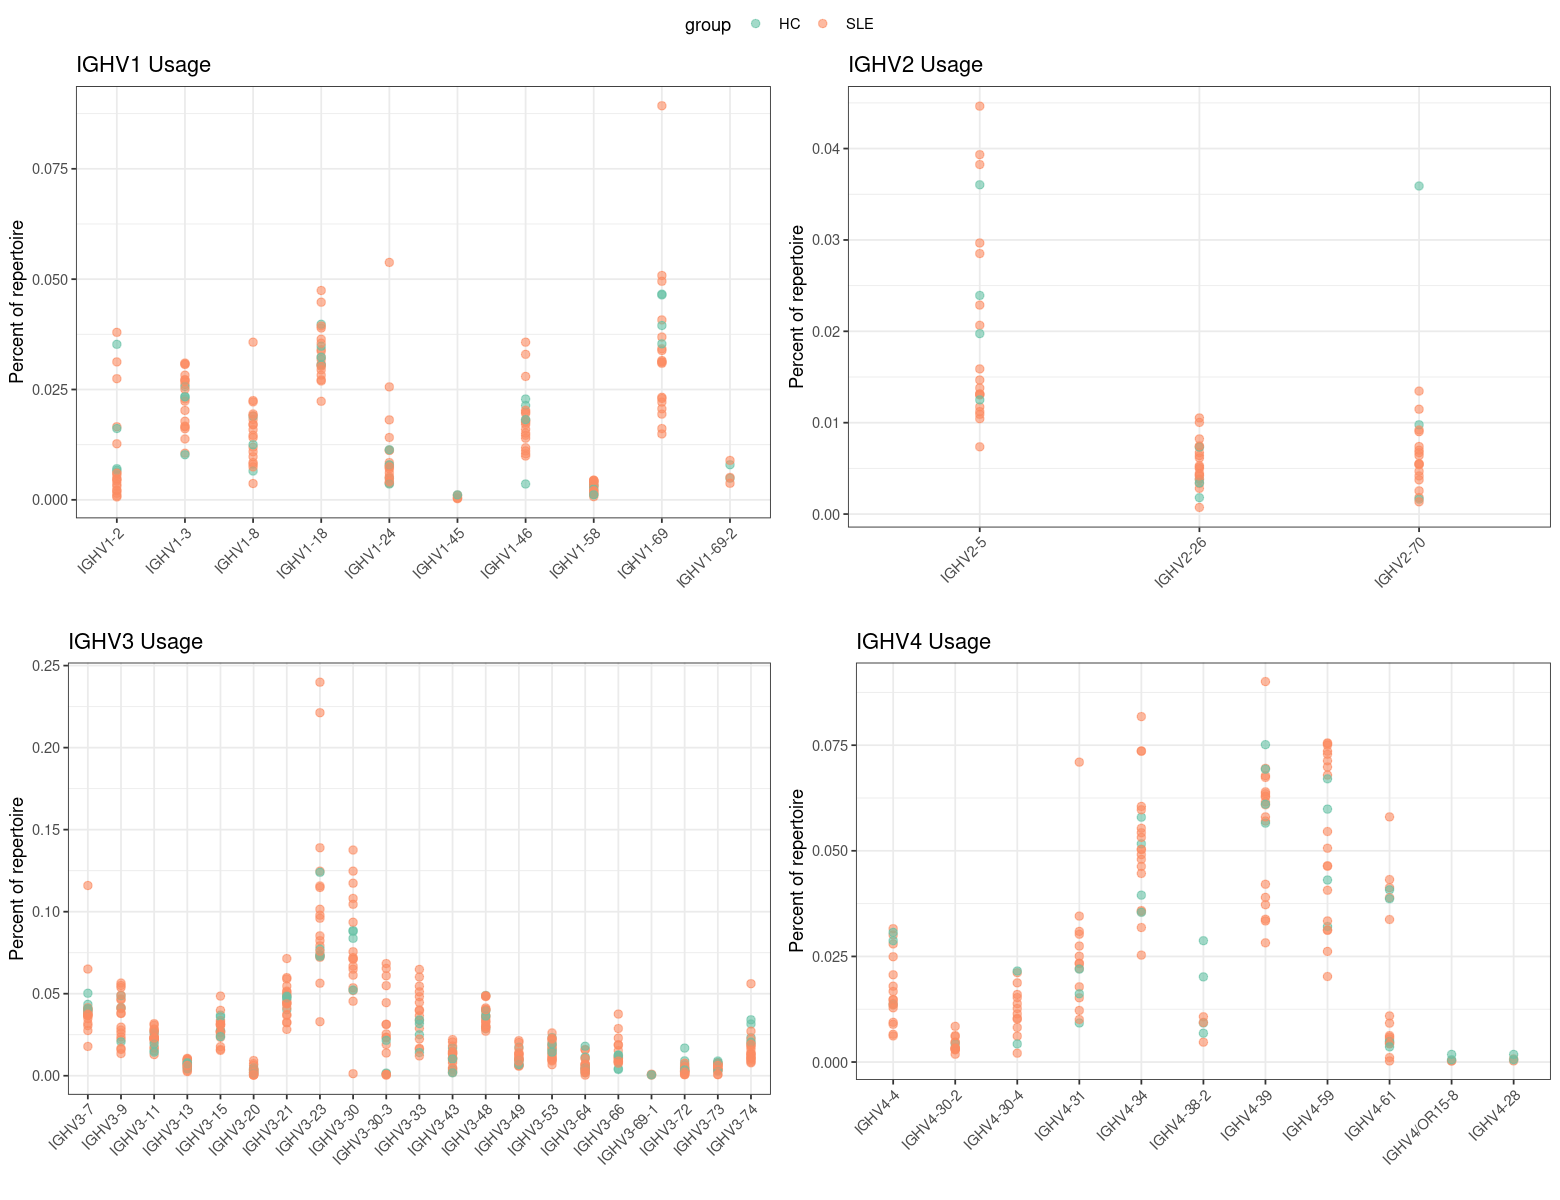

In [97]:
options(repr.plot.width=13, repr.plot.height=10)
ggarrange(g1,g2,g3,g4,common.legend = TRUE)

## use Fisher test

In [109]:
# all_df$v_call_10x %>% head()
# all_df$v_call %>% head()

[1] "IGHV3-74" "IGHV3-30" "IGHV1-8"  "IGHV3-53" "IGHV3-74" "IGHV3-53"

[1] "IGHV3-74*01"                          
[2] "IGHV3-30*04,IGHV3-30*18,IGHV3-30-3*03"
[3] "IGHV1-8*01"                           
[4] "IGHV3-53*01"                          
[5] "IGHV3-74*03"                          
[6] "IGHV3-53*01"

In [118]:
table(all_df$disease)


   HC   SLE 
 4913 32888 

In [148]:
fisher.result <- data.frame(matrix(NA, ncol =  3, nrow = 0))
for(i in unique(all_df$v_call_10x)){
    this_gene_sle <- all_df %>% filter(disease=='SLE',v_call_10x==i) %>% dim()
    this_gene_hc <- all_df %>% filter(disease=='HC',v_call_10x==i) %>% dim()
    not_this_gene_sle <- table(all_df$disease)[2] - this_gene_sle[1]
    not_this_gene_hc <- table(all_df$disease)[1] - this_gene_hc[1]
    tmp_df <- data.frame("HC" = c(this_gene_hc[1], not_this_gene_hc), "SLE" = c(this_gene_sle[1], not_this_gene_sle),
                     row.names = c("This_gene", "Other"))
    tmp_fisher <- fisher.test(tmp_df)
    fisher.result <- rbind(fisher.result, c(tmp_fisher$p.value,tmp_fisher$conf.int))
    # print('------------')
}

In [149]:
colnames(fisher.result) <- c('p.value','down','up')
rownames(fisher.result) <- unique(all_df$v_call_10x)
fisher.result$gene <- rownames(fisher.result)
fisher.result$mean <- 0.5*(fisher.result$down + fisher.result$up)


,p.value,down,up,gene,mean
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
IGHV3-74,6.70221e-06,1.3017219,1.9356827,IGHV3-74,1.6187023
IGHV3-30,7.56156e-19,0.3313266,0.5184145,IGHV3-30,0.4248705


In [155]:
fisher.result %<>% filter(mean < 10)

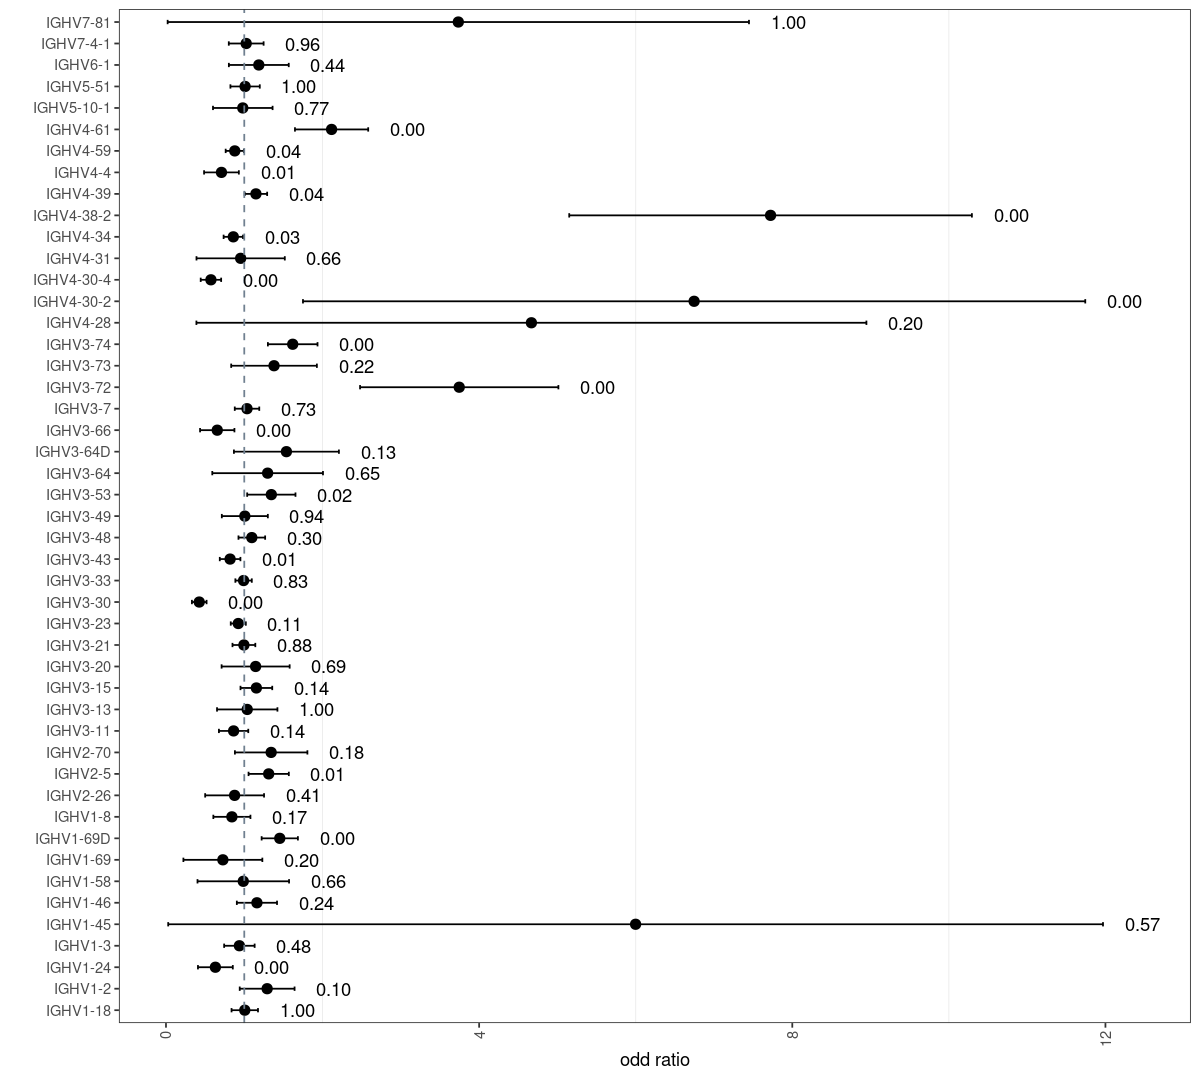

In [208]:
options(repr.plot.width =10, repr.plot.height=9)
ggplot(fisher.result, aes(x=gene, y=mean)) + 
  geom_point(size = 2.5)+ xlab('') + ylab('odd ratio')  +
  geom_errorbar(aes(ymin=down, ymax=up), width=.2,
                position=position_dodge(0.05)) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
geom_hline(aes(yintercept=1), colour="#708090", linetype="dashed") +
  geom_text(aes(x = gene, y = up, label = sprintf("%.2f", p.value)), nudge_y = 0.5)+
    coord_flip() + theme(panel.grid.major=element_line(colour=NA)) 

## J gene

In [184]:
 gene_usage_all_j <- countGenes(all_df, gene="j_call", groups="sample", mode="gene")
options(repr.plot.width=13, repr.plot.height=10) gene_usage_all_j$gene %>% table()

.
IGHJ1 IGHJ2 IGHJ3 IGHJ4 IGHJ5 IGHJ6 
   22    22    22    22    22    22 

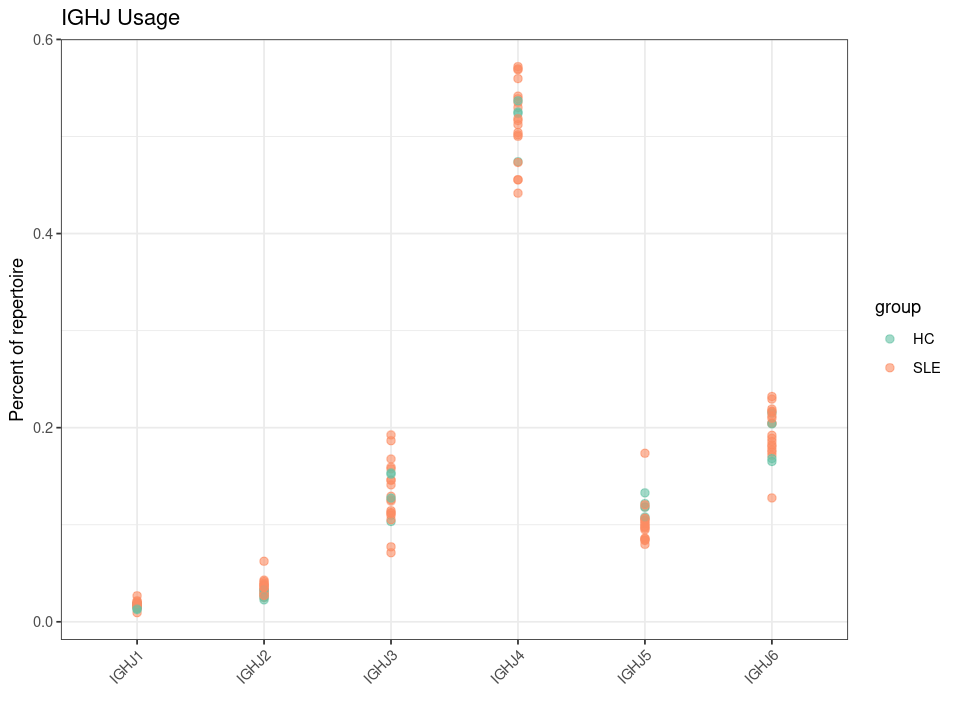

In [186]:
options(repr.plot.width =8, repr.plot.height=6)
gene_usage_all_j %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    # filter(getFamily(gene) == "IGHV1") %>% 
    left_join(meta,by = c('sample'='name')) %>%
    ggplot( aes(x=gene, y=seq_freq)) +
    theme_bw() +ggtitle("IGHJ Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +xlab("") +
    # scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set2") +
    geom_point(aes(color=group), size=2, alpha=0.6)

In [187]:
fisher.result.j <- data.frame(matrix(NA, ncol =  3, nrow = 0))
for(i in unique(all_df$j_call_10x)){
    this_gene_sle <- all_df %>% filter(disease=='SLE',j_call_10x==i) %>% dim()
    this_gene_hc <- all_df %>% filter(disease=='HC',j_call_10x==i) %>% dim()
    not_this_gene_sle <- table(all_df$disease)[2] - this_gene_sle[1]
    not_this_gene_hc <- table(all_df$disease)[1] - this_gene_hc[1]
    tmp_df <- data.frame("HC" = c(this_gene_hc[1], not_this_gene_hc), "SLE" = c(this_gene_sle[1], not_this_gene_sle),
                     row.names = c("This_gene", "Other"))
    tmp_fisher <- fisher.test(tmp_df)
    fisher.result.j <- rbind(fisher.result.j, c(tmp_fisher$p.value,tmp_fisher$conf.int))
    # print('------------')
}

In [192]:
fisher.result.j

,p.value,down,up
,<dbl>,<dbl>,<dbl>
IGHJ4,4.503405e-02,0.8853405,0.9991024
IGHJ5,2.649179e-05,1.1133313,1.3429258
IGHJ6,4.046399e-01,0.9564043,1.1137595
IGHJ3,3.835866e-01,0.8779494,1.0501916
IGHJ2,2.785437e-03,0.6295776,0.9138403
IGHJ1,1.306001e-01,0.9449248,1.4475121


In [193]:
colnames(fisher.result.j) <- c('p.value','down','up')
rownames(fisher.result.j) <- unique(all_df$j_call_10x)
fisher.result.j$gene <- rownames(fisher.result.j)
fisher.result.j$mean <- 0.5*(fisher.result.j$down + fisher.result.j$up)

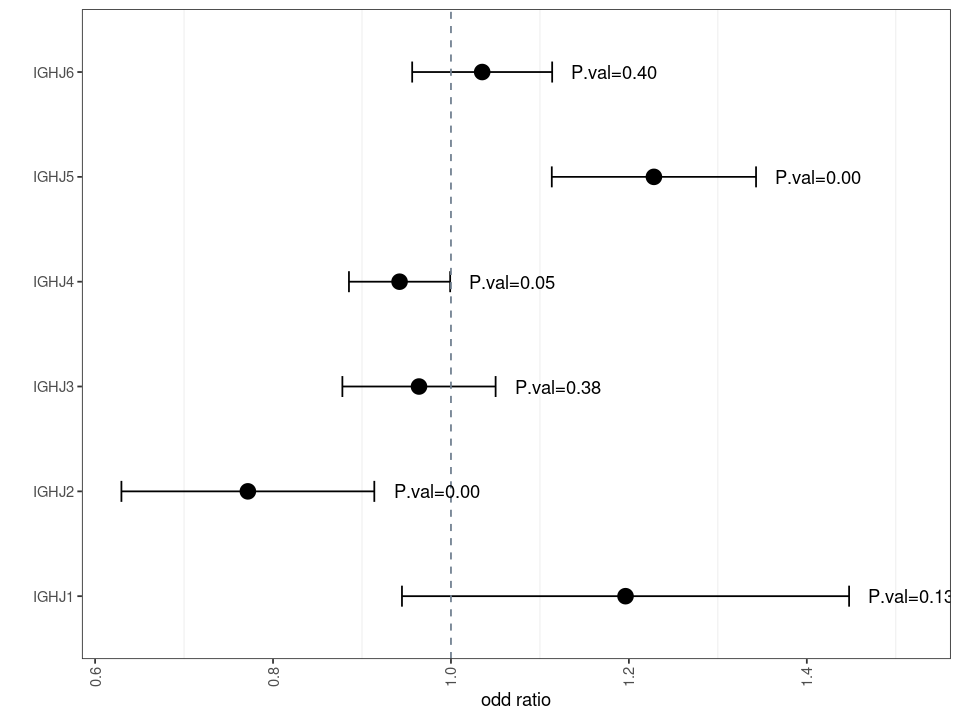

In [204]:
ggplot(fisher.result.j, aes(x=gene, y=mean)) + 
  geom_point(size = 4)+ xlab('') + ylab('odd ratio')  +
  geom_errorbar(aes(ymin=down, ymax=up), width=.2,
                position=position_dodge(0.05)) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
geom_hline(aes(yintercept=1), colour="#708090", linetype="dashed") +
  geom_text(aes(x = gene, y = up, label = paste0('P.val=',sprintf("%.2f", p.value))), 
            nudge_y =0.07 )+
    coord_flip() + theme(panel.grid.major=element_line(colour=NA)) 

# Physics and chemsitry  properties 

In [219]:
all_df %<>% filter(c_call != '')
db_props <- aminoAcidProperties(all_df, seq="junction", trim=TRUE, 
                                label="cdr3")

# The full set of properties are calculated by default
# dplyr::select(db_props[1:3, ], starts_with("cdr3"))

In [229]:
aa_g1 <-  ggboxplot(db_props, "c_call", "cdr3_aa_length", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")
aa_g2 <-  ggboxplot(db_props, "c_call", "cdr3_aa_gravy", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")
aa_g3 <-  ggboxplot(db_props, "c_call", "cdr3_aa_basic", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")
aa_g4 <-  ggboxplot(db_props, "c_call", "cdr3_aa_acidic", color = "disease",
     palette = c("#4169E1", "#FF8C00"))+
    theme_bw() + stat_compare_means(aes(group = disease), label = "p.signif")

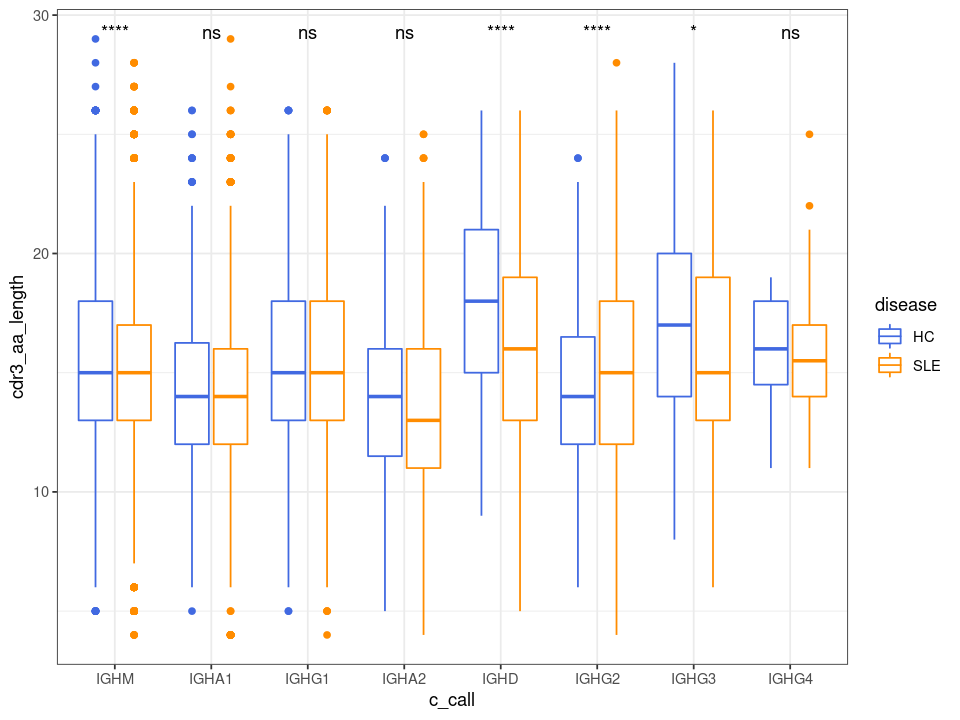

In [256]:
options(repr.plot.width =8, repr.plot.height=6)
aa_g1

$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

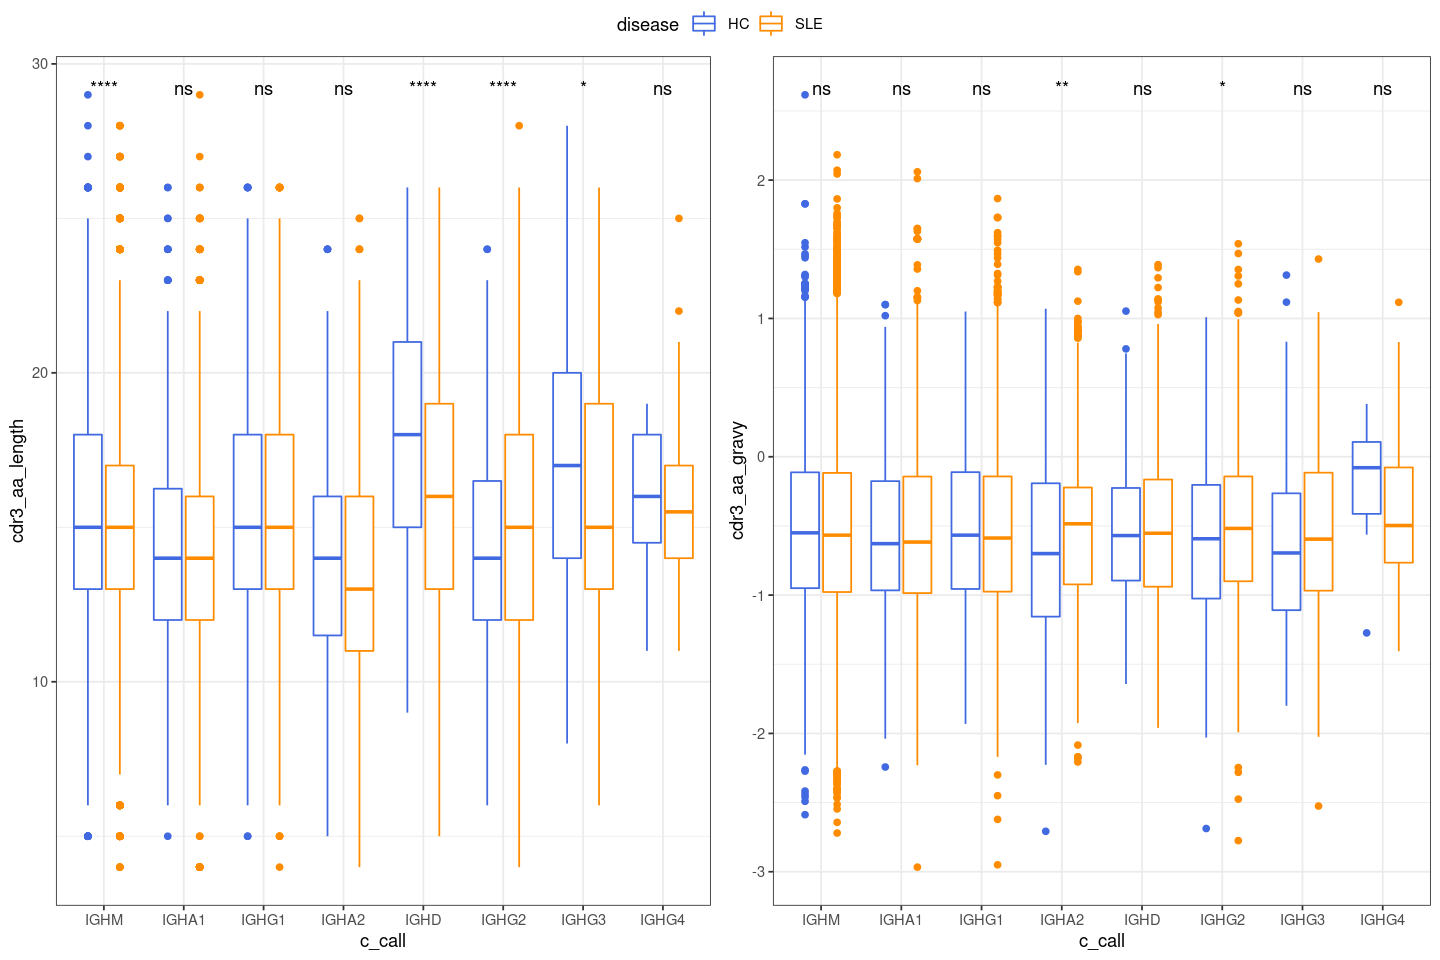

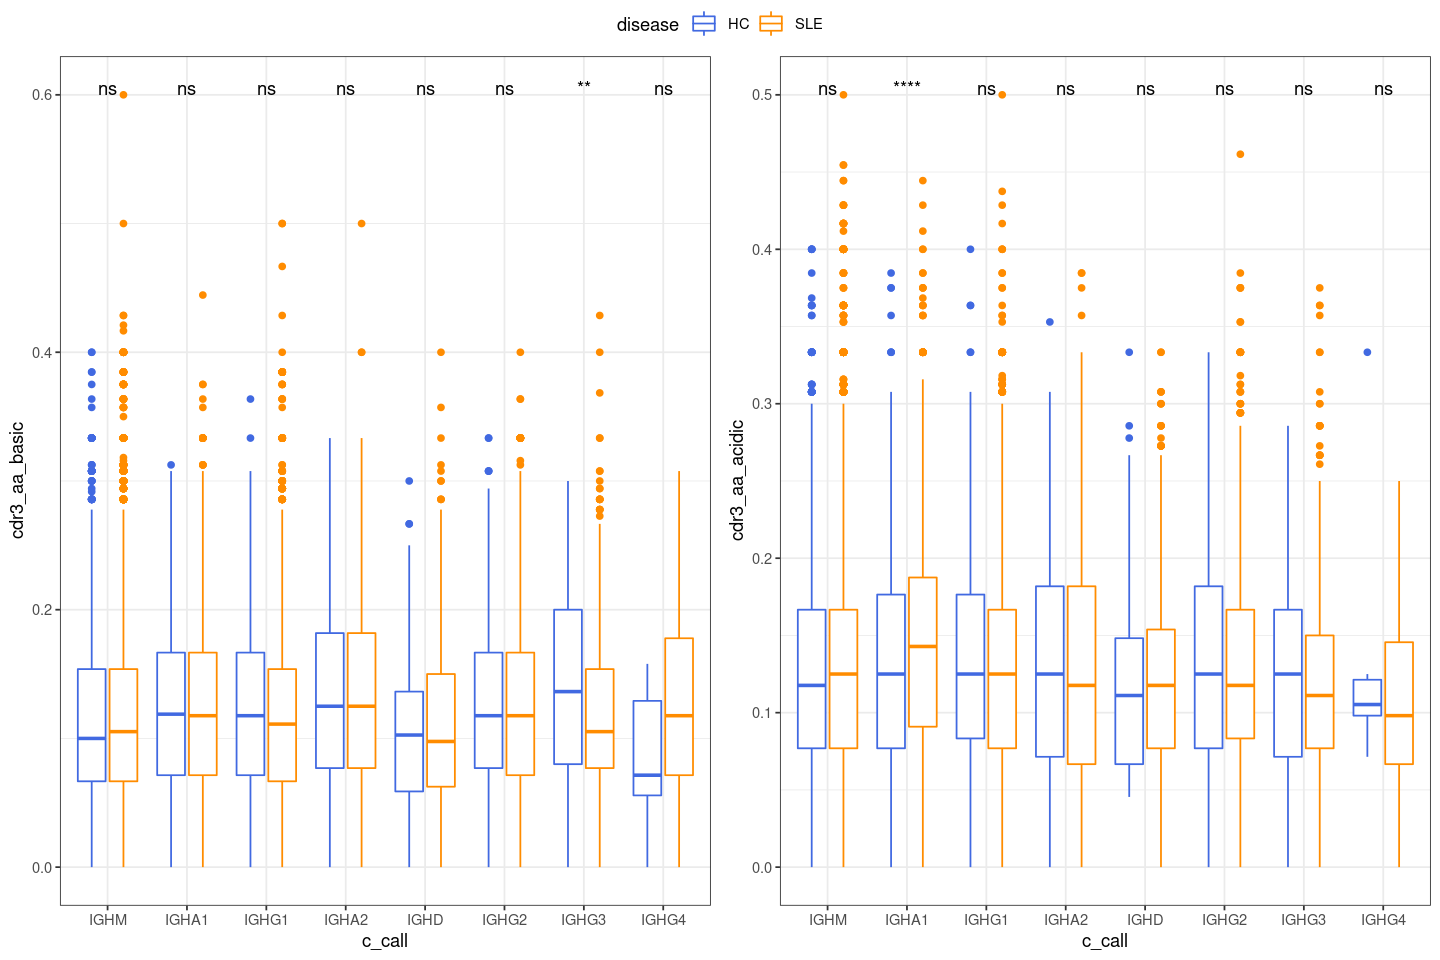

In [232]:
options(repr.plot.width =12, repr.plot.height=8)
# tmp_theme <- theme_bw() + theme(legend.position="bottom")
ggarrange(aa_g1, aa_g2, aa_g3, aa_g4, ncol=2,common.legend = TRUE)

# Choose presure(can not work now)

In [233]:
clones <- collapseClones(all_df, cloneColumn="clone_id", 
                         sequenceColumn="sequence_alignment", 
                         germlineColumn="germline_alignment_d_mask", 
                         regionDefinition=IMGT_V, 
                         method="thresholdedFreq", minimumFrequency=0.6,
                         includeAmbiguous=FALSE, breakTiesStochastic=FALSE, 
                         nproc=24)

ERROR: Error in {: task 268 failed - "Expecting all sequences in the same clone with the same junction lenght."


In [245]:
all_df$clone_id %>% unique() %>% length()

[1] 33224